<a href="https://colab.research.google.com/github/hyh-sherry/concord_chatbot/blob/master/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import packages

In [1]:
import sklearn
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from IPython.display import HTML
#from google.colab import files
import cv2

# 2 Data preprocessing

## CSV data

In [ ]:
# uploaded = files.upload()

Saving yellowknife.jpg to yellowknife.jpg


Upload dest_data.csv

In [2]:
destination = pd.read_csv('data/dest_data_latest.csv')
del destination["Unnamed: 0"]
destination.head()

,Dest_Name,Temp,Budget,Purpose,Language,Family_Friendly
0,Montreal,Cold,High,Business,FR,Y
1,Toronto,Hot,High,Business,EN,Y
2,Halifax,Warm,High,Leisure,EN,Y
3,Vancouver,Hot,Med,Business,EN,Y
4,Ottawa,Warm,Med,Leisure,EN,Y


Upload customer.csv

In [3]:
data=pd.read_csv('data/customer_v5.csv')
data.head()

,Unnamed: 0,Name,Gender,Age,Destination_Category,Temperature,Budget,Purpose,Num_of_People,Families,Duration,Travel Months,Transportation,Hobby,Language
0,0,Kimberly Shea,Female,49,Mountain,Hot,Medium,Leisure,2,1,10,October,Ferry,Creative Arts,EN
1,1,Evelyn Cox,Female,25,Photography Expedition,Warm,High,Business,2,0,8,September,Train,Creative Arts,EN
2,2,Caleb Mccormick,Male,64,Village,Warm,Low,Business,3,0,8,September,Car,Creative Arts,EN
3,3,Christopher Rodriguez,Male,24,Ski Resort,Hot,Low,Leisure,1,0,14,November,Airplane,Intellectual Pursuits,FR
4,4,Rebecca Jackson,Male,22,City,Cold,High,Leisure,5,0,2,September,Train,Intellectual Pursuits,FR


Upload airfare_data.csv

In [5]:
air = pd.read_csv('data/airfare_data_v3.csv')
air.head()

,Unnamed: 0,Flight,price_day1,price_day2,price_day3,price_day4,price_day5,price_day6,price_day7,price_day8,...,price_day21,price_day22,price_day23,price_day24,price_day25,price_day26,price_day27,price_day28,price_day29,price_day30
0,0,YUL-YYZ,507,290,434,315,259,227,280,420,...,299,350,425,462,312,267,431,223,386,475
1,1,YHZ-YYZ,328,568,261,586,311,541,593,673,...,473,414,404,515,247,277,469,330,250,446
2,2,YVR-YYZ,904,762,789,858,785,870,715,766,...,680,573,672,740,859,955,575,715,680,604
3,3,YOW-YYZ,448,213,202,254,179,190,220,170,...,270,232,403,481,434,414,159,277,378,479
4,4,YWG-YYZ,1030,1136,753,1233,1239,924,1034,1226,...,1378,1069,1488,649,574,1348,1262,1302,1192,763


Upload single_city_cost_CAN.csv

In [6]:
from scipy.stats import zscore
cost = pd.read_csv('data/single_city_cost_CAN.csv')
cost.head()
cost['number_day']=pd.DataFrame(pd.to_datetime(cost['end_date'])-pd.to_datetime(cost['start_date']))
cost['number_day']=cost['number_day'].dt.days
cost['other_transport'] = pd.to_numeric(cost['other_transport'])
cost['lodging'] = pd.to_numeric(cost['lodging'])
cost['meals'] = pd.to_numeric(cost['meals'])
cost['other_expenses'] = pd.to_numeric(cost['other_expenses'])

## Travel tips dict

In [7]:
montreal = {
    "Summary Tips": "Welcome to Montreal, a vibrant city in Quebec, Canada. It's known for its unique blend of old-world charm and modern energy. You can immerse yourself in a variety of experiences, from enjoying exquisite cuisine to exploring the city's rich history. The influence of both French and English cultures is palpable in every aspect of life here.",
    "Transportation": "Getting around Montreal is convenient thanks to its efficient Metro system. The city also promotes biking, offering bike lanes and rentals for eco-friendly travel. While driving is an option, be prepared for traffic congestion and limited parking availability, especially in the downtown area.",
    "Culture": "Montreal boasts a bilingual culture where both French and English are widely spoken. Dive into the local art scene by visiting numerous art galleries and museums. The city hosts vibrant festivals throughout the year, celebrating music, culture, and more. Don't miss out on trying iconic dishes like poutine, a mouthwatering combination of fries, cheese curds, and gravy, as well as Montreal-style bagels, known for their distinct texture and taste.",
    "Language": "While French is the official language of Montreal, you'll find that many residents are bilingual and can communicate comfortably in English. This makes it easier for English-speaking visitors to navigate the city without language barriers.",
    "Weather": "Montreal experiences all four seasons distinctly. Winters are cold and snowy, with temperatures often dropping below freezing. Summers are warm and pleasant, with some humidity. Spring and fall offer mild temperatures but can be unpredictable, so it's advisable to dress in layers and be prepared for changing weather conditions.",
    "Photography Spots": "For capturing the essence of Montreal, head to Mount Royal Park, which offers stunning skyline views from its lookout points. Old Montreal is a treasure trove of historic architecture, charming streets, and cobblestone pathways that make for excellent photos. The Notre-Dame Basilica, with its intricate design and stunning interiors, is another fantastic spot for photography enthusiasts.",
    "Shopping": "Indulge in retail therapy on St. Catherine Street, one of Montreal's main shopping districts. Here, you'll find a mix of boutiques, department stores, and international brands, offering a diverse shopping experience. For a taste of local flavor, visit Marché Jean-Talon, a bustling farmers' market where you can shop for fresh produce, artisanal goods, and Quebec specialties.",
    "Tipping": "When dining out in Montreal, it's customary to leave a tip as a gesture of appreciation for good service. The standard tip ranges from 15% to 20% of the total bill. This practice reflects the high-quality dining experiences the city has to offer.",
    "Internet": "Stay connected throughout Montreal with the availability of Wi-Fi in various cafes, restaurants, and public spaces across the city. This makes it convenient for tourists to access information and communicate while exploring.",
}
vancouver = {
    "Summary Tips": "Welcome to Vancouver, a city known for its perfect blend of natural beauty and urban vibrancy. Here, you can expect a range of outdoor activities, artistic experiences, and a multicultural tapestry that reflects the city's diverse population. Make sure to take in the breathtaking landscapes and explore the various neighborhoods that contribute to Vancouver's unique character.",
    "Transportation": "Navigating Vancouver is a breeze thanks to the efficient public transportation system. The SkyTrain and buses provide convenient access to various parts of the city, and exploring on foot is a great way to discover hidden gems. For a more adventurous mode of transportation, consider renting a bike to explore Vancouver's bike-friendly routes. Keep in mind that traffic congestion can occur, especially during peak hours.",
    "Culture": "Vancouver's culture is a rich tapestry woven from its diverse population. Don't miss the opportunity to explore Granville Island, a hub for artists and creators. Here, you'll find galleries, studios, and a vibrant market showcasing local crafts and produce. The city's culinary scene is equally diverse, with a wide range of dining options that reflect its multicultural makeup.",
    "Language": "English is the primary language spoken in Vancouver, making communication easy for English speakers. You'll find that most signs, menus, and services are offered in English, contributing to a seamless experience for visitors.",
    "Weather": "Vancouver's climate is characterized by its mild temperatures throughout the year. Summers are pleasant with warm temperatures, while winters are relatively mild. However, rain is a common occurrence, particularly in the fall and winter months. It's advisable to pack layers and include a raincoat or umbrella in your essentials.",
    "Photography Spots": "Vancouver offers numerous picturesque spots for photography enthusiasts. Stanley Park provides stunning views of the city's skyline along with lush greenery. The Capilano Suspension Bridge offers an adrenaline-pumping experience and breathtaking vistas. English Bay is known for its vibrant sunsets and lively atmosphere, making it a prime spot for capturing the city's dynamic spirit.",
    "Shopping": "Retail therapy is a must in Vancouver, and you can start on Robson Street or Granville Street. Robson Street offers a mix of international brands and local boutiques, while Granville Street is known for its entertainment scene and shopping options. Both areas provide a diverse range of shopping experiences for visitors.",
    "Tipping": "When dining out in Vancouver, it's customary to leave a tip as a sign of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the local custom and reflecting the high quality of service in the city's restaurants.",
    "Internet": "Stay connected during your Vancouver exploration, as Wi-Fi is readily available in cafes, restaurants, and public spaces throughout the city. This accessibility allows you to easily share your memorable moments and stay connected with loved ones.",
}

toronto = {
    "Summary Tips": "Welcome to Toronto, a city that embodies diversity, culture, and entertainment. As you explore its various neighborhoods, you'll encounter iconic landmarks, experience a fusion of cultures, and immerse yourself in a dynamic blend of entertainment and arts.",
    "Transportation": "Getting around Toronto is convenient with several transportation options. The subway and streetcars provide efficient connectivity, and exploring on foot is a great way to discover the city's distinct neighborhoods. Due to potential traffic congestion, especially in the downtown core, consider using the well-connected public transit system to navigate the city with ease.",
    "Culture": "Toronto boasts a vibrant cultural scene, with numerous museums, theaters, and art galleries to explore. Its multiculturalism is particularly evident in the food scene, where you can find a diverse array of international cuisines. From ethnic neighborhoods to upscale dining, Toronto's culinary landscape reflects its cosmopolitan population.",
    "Language": "English is the predominant language spoken in Toronto, ensuring smooth communication for English speakers. Most signs, services, and interactions will be in English, making it easy for visitors to navigate the city and engage with locals.",
    "Weather": "Toronto experiences a range of temperatures throughout the year. Summers can be warm and humid, while winters can be cold and snowy. Spring and fall offer milder weather. It's advisable to check the weather forecast before packing to ensure you're prepared for the varying conditions.",
    "Photography Spots": "Capture the essence of Toronto through your lens at some of its iconic photography spots. The CN Tower offers breathtaking skyline views, showcasing the city's modern architecture. The Distillery District exudes artistic charm with its historic buildings, galleries, and boutiques. The Toronto Islands provide a serene escape and offer picturesque vistas of the city's skyline from across the water.",
    "Shopping": "Indulge in a shopping spree in Toronto, particularly on iconic streets like Robson Street and Granville Street. These areas offer a wide range of shopping options, from high-end boutiques to popular brands, allowing visitors to find the perfect items to take home as souvenirs.",
    "Tipping": "When dining out in Toronto, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, reflecting the high quality of service and hospitality offered by the city's restaurants.",
    "Internet": "Stay connected and share your Toronto experiences, as Wi-Fi is readily accessible throughout the city. You can easily stay in touch with loved ones and share your memorable moments on social media.",
}

halifax = {
    "Summary Tips": "Welcome to Halifax, a charming coastal city known for its maritime heritage, fresh seafood, and historic sites. Here, you can immerse yourself in the unique blend of maritime culture and modern amenities, all set against the stunning backdrop of the Atlantic Ocean. Don't miss the opportunity to explore the picturesque waterfront and savor the local culinary delights that Halifax has to offer.",
    "Transportation": "Navigating Halifax is easy and convenient. You can explore the city on foot, particularly in the downtown area, or take advantage of the well-connected bus network for efficient transportation. Driving is also a viable option for those who prefer the flexibility of having their own vehicle.",
    "Culture": "Halifax offers a rich cultural experience with its maritime history and vibrant festivals. The Halifax Citadel is a must-visit, offering insights into the city's past as a key naval station. Additionally, the city hosts various cultural events and festivals that celebrate its heritage and showcase local talent.",
    "Language": "English is the predominant language spoken in Halifax, ensuring seamless communication for English-speaking visitors. You'll find that most signs, services, and interactions are conducted in English, making it easy to navigate the city and engage with locals.",
    "Weather": "Halifax's climate is influenced by its coastal location, resulting in unpredictable weather conditions. It's advisable to pack layers to accommodate potential temperature fluctuations. Additionally, the city is known for its fog and changeable weather patterns, so having a raincoat or umbrella on hand can be useful.",
    "Photography Spots": "Capture the essence of Halifax through your camera lens at some of its most iconic photography spots. Peggy's Cove, with its famous lighthouse against a rocky backdrop, offers picturesque scenes of coastal beauty. The Halifax Waterfront is a lively area that offers stunning views of the harbor, while the Public Gardens provide a serene and colorful setting for capturing natural beauty.",
    "Shopping": "For a shopping and dining experience, make sure to visit Spring Garden Road. This vibrant area is home to a variety of shops, boutiques, cafes, and restaurants, making it a perfect place to explore and unwind.",
    "Tipping": "When dining out in Halifax, it's customary to leave a tip as a sign of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, reflecting the quality of service offered by the city's restaurants.",
    "Internet": "Stay connected during your Halifax visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility allows you to easily share your experiences, access information, and stay connected with friends and family.",
}

ottawa = {
    "Summary Tips": "Welcome to Ottawa, the capital city of Canada! This vibrant city invites you to immerse yourself in its rich history, cultural institutions, and dynamic festivals. From iconic landmarks to captivating museums, Ottawa offers a blend of heritage and modernity that reflects the heart of the nation.",
    "Transportation": "Navigating downtown Ottawa is a breeze, whether you choose to explore on foot or hop on a convenient bus. Driving is manageable within the city, but considering the well-connected public transit system can enhance your mobility. Exploring on foot provides a unique opportunity to discover the city's charm and architectural beauty.",
    "Culture": "Ottawa is home to several must-visit cultural attractions. Parliament Hill stands as a symbol of Canada's democracy and offers tours for an insight into the country's political history. Museums like the National Gallery of Canada and the Canadian Museum of History offer a diverse array of artistic and historical exhibits. The iconic Rideau Canal transforms into a picturesque ice skating rink during winter and is a serene waterway during the warmer months. Don't miss the Canadian Tulip Festival, a celebration of spring's arrival.",
    "Language": "Ottawa's linguistic tapestry is enriched by both English and French, which are official languages in Canada. You'll find that signage, services, and interactions are available in both languages, contributing to the bilingual nature of the city and providing a unique cultural experience.",
    "Weather": "Ottawa experiences distinct seasons. Winters are characterized by cold temperatures and snowfall, while summers bring warmth and sunshine. Spring and fall offer milder temperatures but can be unpredictable. When packing, be prepared for varying weather conditions and make sure to include appropriate clothing for different seasons.",
    "Photography Spots": "Capture the essence of Ottawa's beauty through your camera lens at some of its most photogenic spots. Parliament Hill, with its stunning Gothic architecture, makes for a majestic subject. The serene Rideau Canal offers picturesque vistas, particularly during sunset. ByWard Market is a lively and colorful area that provides vibrant photo opportunities.",
    "Shopping": "Indulge in retail therapy during your Ottawa visit. Sparks Street Mall offers a pedestrian-friendly shopping experience with a mix of boutiques, galleries, and cafes. The bustling ByWard Market is another shopping destination known for its variety of shops, eateries, and artisanal goods.",
    "Tipping": "When dining out in Ottawa, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, reflecting the high-quality dining experiences the city has to offer.",
    "Internet": "Stay connected throughout your stay in Ottawa, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can stay in touch with loved ones and share your memorable experiences online.",
}

manitoba = {
    "Summary Tips": "Welcome to Manitoba, a province known for its friendly hospitality, rich history, and vibrant cultural festivals. From its historic sites to its lively events, Manitoba offers a range of experiences that showcase the heart of the province and its diverse communities.",
    "Transportation": "Getting around Manitoba can be done through driving or utilizing the public transportation system. Depending on your preferences and the areas you plan to explore, driving provides flexibility, while public transportation offers convenience, especially within urban centers.",
    "Culture": "Manitoba offers a mix of cultural attractions and experiences. The Forks, located at the confluence of the Red and Assiniboine Rivers, is a hub of activity that features shopping, dining, and entertainment options. The Canadian Museum for Human Rights in Winnipeg is a must-visit institution that explores the history and significance of human rights around the world. Throughout the year, you can also enjoy various local festivals that celebrate the province's culture and heritage.",
    "Language": "English is the primary language spoken in Manitoba, making communication straightforward for English-speaking visitors. You'll find that signage, services, and interactions are primarily conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Manitoba experiences diverse weather conditions throughout the year. Winters are marked by cold temperatures and snowfall, while summers bring warmth and sunshine. It's important to pack accordingly for the varying weather, ensuring you have appropriate clothing for both cold and warm seasons.",
    "Photography Spots": "Capture the beauty of Manitoba's landscapes and cityscapes through your camera lens. The Forks offers a charming and vibrant backdrop for photos, while Assiniboine Park provides a tranquil and natural setting. The Exchange District in Winnipeg boasts historic architecture and artistic flair, making it a great spot for capturing unique shots.",
    "Shopping": "If you're in the mood for shopping, The Forks Market in Winnipeg offers a variety of shops and local artisanal goods. Polo Park is another shopping destination where you can find a mix of retail stores, making it easy to indulge in a shopping spree.",
    "Tipping": "When dining out in Manitoba, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Manitoba visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can stay in touch, access information, and share your experiences online.",
}

saskatoon = {
    "Summary Tips": "Welcome to Saskatoon, a city that invites you to explore its riverfront beauty, thriving local art scene, and a variety of outdoor attractions. Whether you're strolling along the riverbank, immersing yourself in indigenous heritage, or enjoying the city's festivals, Saskatoon offers a mix of experiences that showcase its unique character.",
    "Transportation": "Getting around Saskatoon can be done through driving or utilizing the local bus system. If you prefer flexibility, driving allows you to explore the city and its surroundings at your own pace. Alternatively, local buses offer convenient and eco-friendly transportation options within the city.",
    "Culture": "Immerse yourself in Saskatoon's cultural offerings, such as a visit to Wanuskewin Heritage Park, where you can learn about indigenous history and the natural environment. Don't miss the Saskatoon Folkfest, an annual multicultural event celebrating the city's diversity. Explore local art galleries to discover a range of creative expressions by talented artists from the area.",
    "Language": "English is the primary language spoken in Saskatoon, ensuring effective communication for English-speaking visitors. You'll find that most signage, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Saskatoon experiences distinct seasons. Winters are characterized by cold temperatures and snowfall, while summers bring warmth and sunshine. It's important to pack accordingly for both cold and warm weather conditions, ensuring you have suitable clothing for varying temperatures.",
    "Photography Spots": "Capture the natural and architectural beauty of Saskatoon through your camera lens. Meewasin Valley offers picturesque riverfront views and trails for serene shots. Broadway Bridge's unique charm and architecture make it a great subject for photos. Saskatoon Forestry Farm Park provides a tranquil setting with lush greenery, making it an ideal spot for nature photography.",
    "Shopping": "If you're in the mood for shopping, consider visiting Midtown Plaza, a downtown shopping destination featuring a variety of retail stores. Broadway Avenue is another shopping hotspot known for its boutiques, cafes, and local shops, offering a unique shopping experience.",
    "Tipping": "When dining out in Saskatoon, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Saskatoon visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

victoria = {
    "Summary Tips": "Welcome to Victoria, a city on Vancouver Island that offers a delightful blend of history, enchanting gardens, and outdoor activities. Whether you're strolling through its charming downtown, immersing yourself in cultural attractions, or enjoying the natural beauty of the island, Victoria promises a memorable and enriching experience.",
    "Transportation": "Getting around Victoria is convenient and accessible. Downtown areas are pedestrian-friendly, allowing you to explore on foot. Local buses offer a reliable mode of transportation for exploring various parts of the city. Whether you prefer leisurely walks or utilizing public transit, Victoria's layout makes it easy to navigate.",
    "Culture": "Victoria boasts a rich cultural scene with attractions that cater to various interests. The Royal BC Museum offers insights into the province's history and cultural heritage, making it a must-visit for history enthusiasts. Butchart Gardens is a world-renowned attraction that showcases breathtaking landscapes and floral beauty. The Inner Harbour is a vibrant area where you can enjoy scenic views, dine by the waterfront, and explore local shops.",
    "Language": "English is the primary language spoken in Victoria, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Victoria enjoys a mild climate with relatively moderate temperatures. Summers are warm and pleasant, while winters are generally mild. It's advisable to pack layers, as weather conditions can vary throughout the day. Having a light jacket or sweater on hand is recommended, especially for cooler evenings.",
    "Photography Spots": "Capture the essence of Victoria's beauty through your camera lens. Butchart Gardens provides enchanting backdrops with its stunning floral displays and serene landscapes. The Inner Harbour is a hub of activity and offers vibrant photo opportunities. Beacon Hill Park's natural charm and lush surroundings make it a picturesque spot for capturing outdoor scenes.",
    "Shopping": "If you're in the mood for shopping, Government Street and Market Square are popular destinations in Victoria. Government Street is known for its boutique shops, galleries, and local eateries. Market Square offers a mix of shops and dining options within a historic setting, creating a unique shopping experience.",
    "Tipping": "When dining out in Victoria, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, reflecting the high-quality dining experiences the city has to offer.",
    "Internet": "Stay connected during your Victoria visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

calgary = {
    "Summary Tips": "Welcome to Calgary, a city that invites you to immerse yourself in western culture, outdoor adventures, and the renowned Calgary Stampede. Whether you're exploring local attractions, experiencing the city's vibrant arts scene, or embracing its western charm, Calgary offers a mix of experiences that showcase its unique character.",
    "Transportation": "Getting around Calgary can be done through driving or utilizing the local transportation options. Driving provides flexibility, allowing you to explore various areas at your own pace. Local transportation options include buses and C-Train services, which offer convenient ways to navigate the city and reach different neighborhoods.",
    "Culture": "The Calgary Stampede is a signature event that celebrates western culture, rodeo, and entertainment. This annual festival draws visitors from near and far to experience the city's vibrant atmosphere, including rodeo competitions, live music, and diverse culinary offerings. Beyond the Stampede, Calgary boasts a range of local attractions and cultural experiences that highlight its unique identity and rich heritage.",
    "Language": "English is the primary language spoken in Calgary, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Calgary experiences variable weather conditions throughout the year. Summers can be warm and pleasant, while winters bring cold temperatures and snowfall. It's advisable to pack layers to accommodate potential temperature fluctuations, ensuring you're prepared for both warm and cool weather.",
    "Photography Spots": "Capture the essence of Calgary's beauty through your camera lens. The Calgary Stampede offers colorful and dynamic photo opportunities, showcasing the excitement and energy of the event. The iconic Calgary Tower provides panoramic views of the city's skyline, making it a must-visit photography spot. The Bow River offers serene vistas and is a popular location for outdoor and landscape photography.",
    "Shopping": "If you're in the mood for shopping, consider exploring The CORE Shopping Centre, a downtown shopping destination featuring a variety of retail stores. Stephen Avenue Walk is another popular area known for its shops, restaurants, and vibrant atmosphere, making it a great place to indulge in retail therapy.",
    "Tipping": "When dining out in Calgary, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Calgary visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

edmonton = {
    "Summary Tips": "Welcome to Edmonton, a city known for its vibrant arts scene, diverse outdoor attractions, and dynamic cultural festivals. Whether you're exploring the city's natural beauty, immersing yourself in its artistic offerings, or enjoying its modern amenities, Edmonton offers a range of experiences that highlight its unique character.",
    "Transportation": "Getting around Edmonton can be done through driving or utilizing the local transportation options. Driving provides flexibility, allowing you to explore different areas of the city at your own pace. Local transportation includes buses and light rail transit (LRT) services, providing convenient ways to navigate the city's neighborhoods.",
    "Culture": "Edmonton offers a mix of cultural attractions and experiences. West Edmonton Mall, one of the largest shopping and entertainment complexes in the world, features a wide range of shops, attractions, and entertainment options. The River Valley parks offer a natural escape within the city, with opportunities for outdoor activities and scenic views. The city's arts scene is vibrant, with local galleries, theaters, and artistic events showcasing the talents of the community.",
    "Language": "English is the primary language spoken in Edmonton, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Edmonton experiences varying weather conditions throughout the year. Summers can be warm, while winters bring cold temperatures and snowfall. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both warm and cool weather.",
    "Photography Spots": "Capture the beauty of Edmonton's landscapes and landmarks through your camera lens. The River Valley parks offer picturesque views of nature within the city, providing opportunities for outdoor and landscape photography. West Edmonton Mall's iconic features and indoor attractions make for interesting and vibrant photo subjects. The Alberta Legislature Building's grand architecture and stunning surroundings offer a majestic backdrop for photos.",
    "Shopping": "If you're in the mood for shopping, West Edmonton Mall is a must-visit destination. With its diverse range of shops, entertainment options, and attractions, the mall provides a unique shopping experience. Old Strathcona is another shopping area known for its boutique shops, cafes, and local businesses, offering a mix of products and experiences.",
    "Tipping": "When dining out in Edmonton, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Edmonton visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

winnipeg = {
    "Summary Tips": "Welcome to Winnipeg, a city that offers friendly hospitality, rich historic sites, and a vibrant culture highlighted by its festivals and events. Whether you're exploring local attractions, immersing yourself in history, or enjoying the city's creative scene, Winnipeg provides a mix of experiences that showcase its unique character.",
    "Transportation": "Getting around Winnipeg is convenient through driving or utilizing the local transportation options. Driving offers flexibility for exploring different areas, while local transportation includes buses and rapid transit services that provide easy access to various neighborhoods and attractions.",
    "Culture": "Winnipeg offers a variety of cultural experiences for visitors to enjoy. The Forks is a historic site and vibrant hub of activity, featuring shops, restaurants, and events. The Canadian Museum for Human Rights is a significant attraction that explores the history and importance of human rights. The city's festivals and events, celebrating everything from arts to diverse cultures, contribute to its lively cultural scene.",
    "Language": "English is the primary language spoken in Winnipeg, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Winnipeg experiences varying weather conditions throughout the year. Winters are marked by cold temperatures and snowfall, while summers bring warmth and sunshine. It's advisable to pack clothing that accommodates the potential temperature fluctuations, ensuring you're prepared for both cold and warm weather.",
    "Photography Spots": "Capture the essence of Winnipeg's landscapes and landmarks through your camera lens. The Forks offers a charming and lively backdrop for photos, capturing the spirit of the city. Assiniboine Park provides a tranquil and natural setting, making it a perfect spot for capturing outdoor scenes. The Exchange District boasts historic architecture and artistic flair, offering unique and captivating photography opportunities.",
    "Shopping": "If you're in the mood for shopping, The Forks Market is a must-visit destination. With its range of shops and local products, the market provides a unique shopping experience. Polo Park is another shopping destination known for its variety of retail stores, making it a convenient place to indulge in retail therapy.",
    "Tipping": "When dining out in Winnipeg, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Winnipeg visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

sherbrooke = {
    "Summary Tips": "Welcome to Sherbrooke, a city that invites you to embrace its charm through historic sites, cultural events, and natural beauty. Whether you're exploring the city's heritage, immersing yourself in its arts scene, or enjoying its scenic landscapes, Sherbrooke offers a mix of experiences that showcase its unique character.",
    "Transportation": "Getting around Sherbrooke can be done through driving or utilizing the local transportation options. Driving provides flexibility for exploring different areas at your own pace. Local transportation includes buses and other services that provide convenient access to various parts of the city.",
    "Culture": "Sherbrooke's cultural offerings include the exploration of historic sites that reflect the city's heritage. Attending cultural events and festivals allows you to immerse yourself in the local arts scene and engage with the community's creative expressions. The city's overall charm and ambiance create an inviting atmosphere for visitors to appreciate.",
    "Language": "French is the primary language spoken in Sherbrooke, contributing to the city's unique cultural identity. While English speakers may encounter some language differences, the city's welcoming nature ensures a positive and enriching experience for all visitors.",
    "Weather": "Sherbrooke experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being prepared with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Sherbrooke's landscapes and landmarks through your camera lens. Mont-Bellevue offers picturesque views and hiking trails that provide opportunities for outdoor and nature photography. Sherbrooke's historic district boasts charming architecture and streetscapes, making it a great subject for capturing the city's history. Lac-des-Nations, a scenic lake, offers serene backdrops for capturing reflections and natural beauty.",
    "Shopping": "If you're in the mood for shopping, consider exploring Carrefour de l'Estrie, a shopping center offering a variety of retail stores. Wellington Street is another shopping area known for its local shops, boutiques, and cafes, providing a unique and enjoyable shopping experience.",
    "Tipping": "When dining out in Sherbrooke, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Sherbrooke visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

mississauga = {
    "Summary Tips": "Welcome to Mississauga, a city that offers a harmonious blend of modernity and natural beauty. Whether you're exploring its parks and green spaces, indulging in shopping experiences, or immersing yourself in cultural activities, Mississauga promises a diverse array of experiences that highlight its unique character.",
    "Transportation": "Getting around Mississauga is convenient through driving or utilizing the local transportation options. Driving offers flexibility for exploring various parts of the city. Local transportation includes buses and other services that provide convenient access to different neighborhoods and attractions.",
    "Culture": "Mississauga offers a range of cultural experiences for visitors to enjoy. Mississauga Celebration Square serves as a hub for community events, festivals, and live performances. Exploring local attractions allows you to engage with the city's history and heritage. The city's overall cultural scene reflects its vibrant and diverse community.",
    "Language": "English is the primary language spoken in Mississauga, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Mississauga experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with appropriate attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Mississauga's landscapes and landmarks through your camera lens. Port Credit offers picturesque waterfront views and a charming atmosphere, making it a great spot for capturing scenic shots. Mississauga Celebration Square's vibrant events and architecture provide dynamic photo opportunities. Kariya Park's serene Japanese garden offers tranquil backdrops for capturing natural beauty.",
    "Shopping": "If you're in the mood for shopping, Square One Shopping Centre is a premier destination. With its diverse range of shops and dining options, the mall provides a comprehensive shopping experience. Heartland Town Centre is another shopping area known for its outlet stores and retail offerings, catering to a variety of shopping preferences.",
    "Tipping": "When dining out in Mississauga, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Mississauga visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

richmond = {
    "Summary Tips": "Welcome to Richmond, a city that invites you to experience its cultural diversity, explore outdoor attractions, and savor its delicious culinary scene. Whether you're immersing yourself in the local culture, indulging in unique dining experiences, or enjoying the city's natural beauty, Richmond offers a range of experiences that highlight its unique character.",
    "Transportation": "Getting around Richmond is convenient through driving or utilizing the local transportation options. Driving offers flexibility for exploring various parts of the city. Local transportation includes buses and other services that provide convenient access to different neighborhoods and attractions.",
    "Culture": "Richmond's cultural diversity is reflected in its local attractions, events, and vibrant community. Exploring the city allows you to engage with its diverse heritage and cultural offerings. Visit local attractions to learn more about the city's history and engage with its dynamic community spirit.",
    "Language": "English is the primary language spoken in Richmond, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Richmond experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Richmond's landscapes and landmarks through your camera lens. Steveston Village offers a charming coastal atmosphere and historic scenery, making it a picturesque location for photography. Iona Beach Regional Park provides serene waterfront views and opportunities for nature photography. Garry Point Park offers scenic vistas, capturing the beauty of the coastline and surrounding landscapes.",
    "Shopping": "If you're in the mood for shopping, Richmond Centre is a popular destination. With its diverse range of shops and dining options, the mall provides a comprehensive shopping experience. Aberdeen Centre is another shopping area known for its Asian-inspired architecture and variety of retail offerings.",
    "Tipping": "When dining out in Richmond, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Richmond visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

whitehorse = {
    "Summary Tips": "Welcome to Whitehorse, a city that invites you to experience its natural beauty, embrace outdoor adventures, and immerse yourself in its rich cultural heritage. Whether you're exploring the pristine landscapes, engaging in outdoor activities, or discovering the city's history, Whitehorse offers a range of experiences that showcase its unique character.",
    "Transportation": "Getting around Whitehorse is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the city and its surroundings. Local transportation includes buses and other services that provide convenient access to different areas.",
    "Culture": "Whitehorse's cultural offerings are intertwined with its natural beauty and outdoor activities. Engage in outdoor adventures that highlight the city's stunning landscapes and diverse ecosystems. Learn about the cultural heritage of the region through museums, exhibits, and interactions with local communities.",
    "Language": "English is the primary language spoken in Whitehorse, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Whitehorse experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Whitehorse's landscapes and landmarks through your camera lens. Miles Canyon offers stunning views and opportunities for capturing the beauty of the flowing water and rugged terrain. Yukon Wildlife Preserve provides unique opportunities for photographing native wildlife in their natural habitats. Kluane National Park boasts breathtaking mountain vistas and scenic landscapes, offering a captivating backdrop for photography.",
    "Shopping": "If you're in the mood for shopping, consider exploring Main Street, where you'll find local shops, boutiques, and charming establishments. North End Gallery showcases Indigenous art, jewelry, and crafts, offering a unique shopping experience that celebrates local talent.",
    "Tipping": "When dining out in Whitehorse, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Whitehorse visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

hamilton = {
    "Summary Tips": "Welcome to Hamilton, a city that invites you to discover its vibrant arts and culture, explore its natural beauty, and savor its diverse food scene. Whether you're immersing yourself in the local arts scene, embarking on outdoor adventures, or indulging in culinary delights, Hamilton offers a range of experiences that highlight its unique character.",
    "Transportation": "Getting around Hamilton is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the city and its surroundings. Local transportation includes buses and other services that provide convenient access to different areas.",
    "Culture": "Hamilton's arts and culture scene is rich and diverse, offering visitors a chance to explore local galleries, theaters, and creative spaces. Visit local attractions to learn more about the city's history and cultural heritage. Additionally, indulge in the city's food scene, which showcases a variety of culinary delights.",
    "Language": "English is the primary language spoken in Hamilton, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Hamilton experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Hamilton's landscapes and landmarks through your camera lens. Royal Botanical Gardens offer stunning displays of flora and fauna, making it a picturesque location for photography. Dundurn Castle provides a glimpse into the city's history with its historic architecture and gardens. Webster's Falls offers a scenic waterfall backdrop that's perfect for capturing natural beauty.",
    "Shopping": "If you're in the mood for shopping, consider exploring Jackson Square, a shopping center offering a range of retail options. Locke Street is another shopping area known for its local boutiques, cafes, and unique shops, providing a charming and distinctive shopping experience.",
    "Tipping": "When dining out in Hamilton, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Hamilton visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

regina = {
    "Summary Tips": "Welcome to Regina, a city that invites you to experience its rich history, cultural attractions, and lively festivals. Whether you're delving into the city's heritage, exploring its cultural offerings, or participating in its vibrant festivals, Regina offers a range of experiences that highlight its unique character.",
    "Transportation": "Getting around Regina is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the city and its surroundings. Local transportation includes buses and other services that provide convenient access to different areas.",
    "Culture": "Regina's cultural attractions offer visitors the chance to explore local museums, galleries, and creative spaces that showcase the city's diverse arts scene. Learn about the history of Regina through its museums and historical sites, and engage in the city's vibrant festival scene, which celebrates the local community and culture.",
    "Language": "English is the primary language spoken in Regina, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Regina experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Regina's landscapes and landmarks through your camera lens. Wascana Centre offers picturesque lakeside views and scenic landscapes, making it a popular photography spot. Saskatchewan Legislative Building boasts impressive architecture and historic significance, providing unique opportunities for capturing its grandeur. Cathedral Village is known for its charming streets and vibrant community, offering a colorful backdrop for photography.",
    "Shopping": "If you're in the mood for shopping, consider exploring Cornwall Centre, a shopping mall with a range of retail options. Southland Mall is another shopping destination offering a variety of stores and shopping experiences, catering to different preferences.",
    "Tipping": "When dining out in Regina, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Regina visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

yellowknife = {
    "Summary Tips": "Welcome to Yellowknife, a city that offers you the chance to experience its northern beauty, partake in outdoor adventures, and engage with its unique cultural heritage. Whether you're exploring the city's heritage, embarking on outdoor activities, or capturing the beauty of the northern landscapes, Yellowknife provides a range of experiences that showcase its distinctive character.",
    "Transportation": "Getting around Yellowknife is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the city and its surroundings. Local transportation includes buses and other services that offer convenient access to different areas.",
    "Culture": "Yellowknife's cultural heritage is shaped by its unique location and history. Engage in outdoor activities that showcase the city's natural beauty and northern charm. Explore the unique cultural offerings and attractions that provide insights into the city's history and indigenous heritage.",
    "Language": "English is the primary language spoken in Yellowknife, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Yellowknife experiences varying weather conditions throughout the year due to its northern location. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Yellowknife's landscapes and landmarks through your camera lens. Frame Lake Trail offers picturesque lakeside views and opportunities for capturing the city's natural beauty. Old Town Yellowknife boasts historic architecture and a charming atmosphere, providing unique photography opportunities. Aurora Village offers a chance to capture the breathtaking beauty of the northern lights.",
    "Shopping": "If you're in the mood for shopping, consider exploring Centre Square Mall, a shopping center with a range of retail options. Yellowknife Farmers Market is another shopping destination that offers locally produced goods, crafts, and more.",
    "Tipping": "When dining out in Yellowknife, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Yellowknife visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

niagara = {
    "Summary Tips": "Welcome to Niagara, a destination that beckons you to discover its natural wonders, experience thrilling attractions, and indulge in a delicious culinary scene. Whether you're marveling at the awe-inspiring waterfalls, exploring the natural landscapes, or savoring culinary delights, Niagara offers a range of experiences that highlight its unique charm.",
    "Transportation": "Getting around Niagara is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the region and its attractions. Local transportation includes buses and other services that offer convenient access to different areas.",
    "Culture": "Niagara's culture is deeply intertwined with its natural beauty. Explore the region's iconic natural attractions, including the famous Niagara Falls, and immerse yourself in the breathtaking landscapes. Visit local wineries to experience the region's vibrant wine culture, and indulge in culinary delights that showcase the local flavors.",
    "Language": "English is the primary language spoken in Niagara, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Niagara experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the region's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Niagara's landscapes and landmarks through your camera lens. Niagara Falls is a must-capture spectacle with its majestic cascades. Niagara Glen Nature Reserve offers opportunities to capture the region's natural beauty and stunning vistas. Queen Victoria Park provides picturesque views of the falls and well-maintained gardens.",
    "Shopping": "If you're in the mood for shopping, consider exploring Outlet Collection at Niagara, a shopping destination featuring a variety of retail outlets. Clifton Hill is another shopping and entertainment district known for its attractions, shops, and vibrant atmosphere.",
    "Tipping": "When dining out in Niagara, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Niagara visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

vaughan = {
    "Summary Tips": "Welcome to Vaughan, a city that invites you to experience its family-friendly attractions, engage in shopping excursions, and enjoy cultural events. Whether you're exploring the city's attractions suitable for families, embarking on shopping adventures, or participating in cultural events, Vaughan offers a range of experiences that cater to various interests.",
    "Transportation": "Getting around Vaughan is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the city and its surroundings. Local transportation includes buses and other services that offer convenient access to different areas.",
    "Culture": "Vaughan's family-friendly culture is evident through its attractions and events suitable for visitors of all ages. Explore local museums and cultural attractions that offer insights into the city's heritage. Engage in cultural events that celebrate the local community and provide opportunities for shared experiences.",
    "Language": "English is the primary language spoken in Vaughan, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Vaughan experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Vaughan's landscapes and landmarks through your camera lens. Kortright Centre for Conservation offers picturesque natural settings and outdoor vistas, making it a popular photography spot. Vaughan Mills is a premier shopping destination with a distinctive architecture that's worth capturing. Boyd Conservation Area features serene landscapes and waterfront views.",
    "Shopping": "If you're in the mood for shopping, consider exploring Vaughan Mills, a shopping destination featuring a wide range of retail outlets and entertainment options. Promenade Shopping Centre is another shopping destination offering a variety of stores and shopping experiences.",
    "Tipping": "When dining out in Vaughan, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Vaughan visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

banff = {
    "Summary Tips": "Welcome to Banff, a destination that beckons you to discover its stunning mountain landscapes, partake in outdoor activities, and experience the charm of its town. Whether you're exploring the majesty of Banff National Park, engaging in outdoor adventures, or wandering through the charming streets, Banff offers a range of experiences that showcase its unique character.",
    "Transportation": "Getting around Banff is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the area and its surroundings. Local transportation includes buses and other services that offer convenient access to different areas.",
    "Culture": "Banff's culture is deeply intertwined with its natural beauty and outdoor activities. Engage in outdoor adventures that allow you to experience the area's stunning mountain landscapes up close. Visit local attractions that celebrate the region's unique features and provide insights into its history.",
    "Language": "English is the primary language spoken in Banff, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "Banff experiences varying weather conditions due to its mountainous terrain. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the area's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of Banff's landscapes and landmarks through your camera lens. Banff National Park offers picturesque vistas, serene lakes, and breathtaking mountain backdrops, making it a prime photography spot. Lake Louise is renowned for its stunning turquoise waters and surrounding mountain scenery. Bow Falls features a beautiful waterfall and natural surroundings that are perfect for capturing.",
    "Shopping": "If you're in the mood for shopping, consider exploring Banff Avenue, a bustling street with a variety of shops, boutiques, and dining options. Cascade Plaza is another shopping destination offering a range of retail outlets and unique finds.",
    "Tipping": "When dining out in Banff, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your Banff visit, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

london = {
    "Summary Tips": "Welcome to London, Canada, a city that invites you to explore its charm through cultural attractions, lush green spaces, and a vibrant local scene. Whether you're strolling through picturesque parks, engaging with the local arts and culture, or indulging in culinary delights, London offers a diverse array of experiences to enjoy.",
    "Transportation": "Getting around London is convenient through driving or utilizing the local transportation options. Driving provides flexibility for exploring various parts of the city and its neighborhoods. Local transportation includes buses and other services that offer convenient access to different areas.",
    "Culture": "London's culture is reflected in its vibrant arts and cultural attractions. Explore local museums, galleries, and theaters that showcase the city's artistic endeavors. Immerse yourself in the local scene by attending events, festivals, and performances that highlight the creativity and diversity of the community.",
    "Language": "English is the primary language spoken in London, ensuring effective communication for English-speaking visitors. Most signs, services, and interactions are conducted in English, contributing to a seamless experience during your visit.",
    "Weather": "London experiences varying weather conditions throughout the year. It's advisable to pack clothing that accommodates potential temperature fluctuations, ensuring you're prepared for both cold and warm weather. Being equipped with suitable attire will allow you to comfortably explore the city's attractions regardless of the season.",
    "Photography Spots": "Capture the essence of London's landscapes and landmarks through your camera lens. Victoria Park offers a picturesque setting with lush greenery and vibrant flowers. Thames River provides scenic views and opportunities to capture the city's reflections in the water. The historic downtown area features charming architecture and streetscapes that are perfect for photography.",
    "Shopping": "If you're in the mood for shopping, consider exploring Masonville Place, a shopping center featuring a variety of retail outlets and dining options. Covent Garden Market is another shopping destination offering fresh produce, artisanal goods, and unique finds.",
    "Tipping": "When dining out in London, it's customary to leave a tip as a gesture of appreciation for good service. The standard tipping rate ranges from 15% to 20% of the total bill, aligning with the general tipping practices in Canada.",
    "Internet": "Stay connected during your visit to London, as Wi-Fi is readily available in most hotels and public areas. This accessibility ensures that you can easily share your experiences, access information, and stay connected with loved ones.",
}

In [8]:
travel_tips_dict = {
  "montreal": montreal,

  "vancouver": vancouver,

  "toronto": toronto,

  "halifax": halifax,

  "ottawa": ottawa,

  "manitoba": manitoba,

  "london": london,

  "saskatoon": saskatoon,

  "victoria": victoria,

  "calgary": calgary,

  "edmonton": edmonton,

  "winnipeg": winnipeg,

  "sherbrooke": sherbrooke,

  "mississauga": mississauga,

  "richmond": richmond,

  "whitehorse": whitehorse,

  "hamilton": hamilton,

  "regina": regina,

  "yellowknife": yellowknife,

  "niagara": niagara,

  "vaughan": vaughan,

  "banff": banff
}

In [9]:
travel_dest_introductions = {
    "Montreal": "Montreal, located in the province of Quebec, is a vibrant and culturally diverse city known for its rich history, dynamic arts scene, and bustling festivals. The city's blend of French and English heritage is reflected in its architecture, cuisine, and way of life, making it a unique and cosmopolitan destination for visitors and residents alike.",
    "Toronto": "Toronto, the capital of Ontario, is Canada's largest city and a thriving metropolis characterized by its iconic skyline, diverse neighborhoods, and vibrant cultural tapestry. With a strong emphasis on multiculturalism, Toronto boasts a rich array of international cuisines, arts and entertainment venues, and world-class museums. From the historic Distillery District to the bustling Yonge-Dundas Square, Toronto offers a dynamic urban experience that reflects its position as a global hub.",
    "Halifax": "Halifax, the capital of Nova Scotia, is a picturesque maritime city known for its historic charm, stunning waterfront, and welcoming community. With a strong maritime heritage, Halifax offers visitors a chance to explore naval history at the Maritime Museum of the Atlantic, enjoy fresh seafood along the waterfront boardwalk, and take in breathtaking views from the iconic Citadel Hill. The city's blend of history, natural beauty, and maritime culture creates a truly unique atmosphere.",
    "Vancouver": "Vancouver, situated on the southwestern coast of British Columbia, is a city of stunning natural beauty and diverse cultural experiences. Surrounded by mountains, forests, and the Pacific Ocean, Vancouver offers an array of outdoor activities such as hiking, skiing, and kayaking, all within reach of a bustling urban center. The city's multicultural neighborhoods, world-class restaurants, and vibrant arts scene contribute to its reputation as one of the most livable cities in the world.",
    "Ottawa": "Ottawa, the capital of Canada, is a city steeped in history and political significance, boasting an impressive collection of national museums, government buildings, and cultural landmarks. From the iconic Parliament Hill to the bustling ByWard Market, Ottawa offers a blend of historic charm and modern amenities. The city's festivals, including Canada Day celebrations and Winterlude, showcase its lively spirit and commitment to showcasing Canadian culture.",
    "Manitoba": "Manitoba, a Canadian province known for its vast and diverse landscapes, is anchored by the vibrant city of Winnipeg. Winnipeg offers a mix of cultural attractions, historic sites, and natural beauty, including the Forks National Historic Site, the Canadian Museum for Human Rights, and a thriving arts scene. Beyond the city, Manitoba's expansive boreal forests, numerous lakes, and northern beauty make it a paradise for outdoor enthusiasts.",
    "London": "London, situated in southwestern Ontario, is a growing city with a strong focus on education, healthcare, and technology sectors. Home to renowned educational institutions like Western University and Fanshawe College, as well as a burgeoning tech industry, London offers a blend of intellectual stimulation and economic opportunity. The city's cultural scene, including art galleries, theaters, and music festivals, contributes to its vibrant and engaging atmosphere.",
    "Saskatoon": "Saskatoon, located in the province of Saskatchewan, is a prairie city known for its picturesque riverbanks along the South Saskatchewan River, vibrant arts community, and warm hospitality. The city hosts numerous festivals and events, such as the Saskatoon Fringe Theatre Festival and the Saskatchewan Jazz Festival, showcasing its commitment to the arts and culture. With a mix of natural beauty and urban amenities, Saskatoon offers a unique prairie experience.",
    "Victoria": "Victoria, the capital of British Columbia, is a charming city renowned for its British colonial architecture, lush gardens, and temperate coastal climate. The city's iconic landmarks, including the Royal BC Museum and the historic Fairmont Empress Hotel, attract visitors from around the world. Victoria's relaxed pace of life, combined with its focus on outdoor activities such as kayaking, whale watching, and hiking, make it a popular destination for those seeking both cultural enrichment and natural beauty.",
    "Calgary": "Calgary, nestled in the foothills of Alberta's Rocky Mountains, is a city known for its blend of urban sophistication and outdoor adventure. The annual Calgary Stampede, a world-famous rodeo and exhibition, captures the city's western spirit and vibrant energy. With a modern skyline, diverse neighborhoods, and easy access to the natural beauty of the Rockies, Calgary offers a unique combination of cultural experiences and recreational opportunities.",
    "Edmonton": "Edmonton, the capital of Alberta, is a dynamic city known for its thriving arts and culture scene, diverse communities, and expansive river valley park system. The city is home to numerous theaters, galleries, and music venues, as well as hosting events like the Edmonton International Fringe Theatre Festival. With a strong emphasis on outdoor activities, Edmontonians enjoy exploring the North Saskatchewan River valley, the largest urban park in North America.",
    "Winnipeg": "Winnipeg, the capital of Manitoba, is a city of historic significance, cultural diversity, and vibrant festivals. Home to landmarks like The Forks and the Exchange District, Winnipeg's historic sites and architecture tell the story of its past. The city's multicultural neighborhoods, annual events like Folklorama, and strong sense of community contribute to its reputation as a welcoming and lively city.",
    "Sherbrooke": "Sherbrooke, located in the province of Quebec, is a picturesque city surrounded by natural beauty and characterized by its charming downtown, historic architecture, and academic institutions. With a strong focus on education and research, Sherbrooke is home to several universities and research centers. The city's proximity to national parks, lakes, and mountains provides ample opportunities for outdoor exploration and recreational activities.",
    "Mississauga": "Mississauga, a large city in Ontario, is recognized for its modern infrastructure, diverse population, and strong business presence. As part of the Greater Toronto Area, Mississauga offers a range of amenities, including shopping malls, cultural events, and recreational facilities. The city's strategic location and economic opportunities make it a hub for both residential living and commercial activity.",
    "Richmond": "Richmond, located near Vancouver, is a city known for its strong Asian influences, diverse culinary scene, and picturesque waterfront. With a high proportion of residents of Asian descent, Richmond offers a rich cultural experience through its night markets, festivals, and authentic dining options. The city's coastal location and proximity to natural parks make it a popular destination for outdoor enthusiasts and food lovers alike.",
    "Whitehorse": "Whitehorse, the capital of Yukon, offers a unique northern experience with a strong focus on outdoor activities, indigenous culture, and the mesmerizing northern lights. The city serves as a gateway to the wilderness, attracting adventure seekers, wildlife enthusiasts, and those interested in experiencing the magic of the Arctic Circle. Whitehorse's close-knit community and dedication to preserving its heritage create a distinctive and authentic northern atmosphere.",
    "Hamilton": "Hamilton, situated along the shores of Lake Ontario in Ontario, is a city with a rich industrial heritage, a blossoming arts community, and a strong connection to nature. The city's historic steel mills and factories have given way to revitalized neighborhoods, cultural institutions like the Art Gallery of Hamilton, and a burgeoning culinary scene. With its proximity to both urban amenities and natural landscapes, Hamilton offers a balanced and vibrant lifestyle.",
    "Regina": "Regina, the capital of Saskatchewan, is known for its wide streets, parks, and growing arts scene. With a strong emphasis on agriculture, Regina hosts the annual Canada's Farm Progress Show and boasts attractions like the Royal Saskatchewan Museum. The city's friendly atmosphere, combined with its cultural offerings and appreciation for local produce, creates a sense of community and pride among residents.",
    "Yellowknife": "Yellowknife, the capital of the Northwest Territories, is a city surrounded by the rugged beauty of the Arctic wilderness. Known for its stunning northern lights displays, Yellowknife offers a unique opportunity to experience the wonders of the North. The city's indigenous culture, outdoor adventures like dog sledding and ice fishing, and close connection to nature make it a captivating destination for those seeking a true northern experience.",
    "Niagara": "Niagara Falls, located in Ontario, is famous for its breathtaking waterfalls, tourist attractions, and scenic beauty. The iconic Niagara Falls themselves are a powerful natural wonder, drawing visitors from around the globe. Beyond the falls, the region offers a range of activities, from wine tasting in the Niagara Wine Country to exploring historic sites like Old Fort Niagara, making it a popular destination for both nature lovers and history enthusiasts.",
    "Vaughan": "Vaughan, a city in the Greater Toronto Area, is characterized by its diverse communities, entertainment options, and shopping destinations. The city is home to attractions like Canada's Wonderland amusement park and the Vaughan Mills shopping center, offering a mix of family-friendly activities and retail therapy. With its multicultural atmosphere and convenient location, Vaughan provides a modern urban experience with a touch of suburban charm.",
    "Banff": "Banff, situated in the heart of the Alberta Rockies, is renowned for its stunning alpine scenery, outdoor recreational opportunities, and relaxing hot springs. The town is surrounded by Banff National Park, Canada's oldest national park, where visitors can explore pristine lakes, towering mountains, and diverse wildlife. From skiing and hiking to exploring the charming town's galleries and restaurants, Banff offers an unparalleled mountain getaway and a true connection to nature."
}


# 3 Chatbot Implementation

Our chatbot aims to support the customized travel service for Concord Travel Agency.\
We provide four scenarios:
1. Recommendation on destination - Exploration & Discovery \
  In this scenario, we would like to compare the similarity between customer's preference and city characteristics. We will recommend the destination city with the highest similarity to our customer.
2. Travel tips - Culture enrichment \
  In this scenario, we would like to provide some travel tips to the customer based on their selections.
3. Group travel - Building relationships and Connection \
  This scenario would help the customer to connect with other travellers who have the similar travel habits. By doing so, it allows customer to form their own group travel and minimize the conflicts during the trip. We apply k-means clustering method to complete this task.
4. Estimated travel costs  
  This scenario would help the customer to do their travel budget. We apply time series technique to find the future transportation cost, and add this cost with the average local expenses to compute the predicted budget. \

In addition, our chatbot also allows users to keep requesting until they want to quit the program. Combine with the four scenarios, our chatbot could improve customers' experiences on customized travel plan for Concord Travel Agency.


In [10]:
class Chatbot:

  def __init__(self):
    self.destination_cat_opt = ["Mountain","City","Countryside","Island","Ski Resort","Village",
                "Lake","Winery","Spa Retreat","Photography Expedition"]
    self.month_opt = ['September','October', 'November']
    self.transportation_opt = ['Train', 'Airplane', 'Car', 'Bus', 'Ferry']
    self.temperature_opt=['Cold', 'Warm', 'Hot']
    self.num_of_ppl_opt= ['Mini Group(less than 5 people)', 'Normal Group(5 - 10 people)', 'Large Group(10 - 20 people)']
    self.budget_opt = ['Low', 'Medium', 'High']
    self.gender_opt = ['Male', 'Female']
    self.purpose_opt = ['Business', 'Leisure']
    self.hobby_opt = ['Creative Arts', 'Physical Sports', 'Outdoor Exploration', 'Culinary', 'Intellectual Pursuits']
    self.language_opt = ['EN', 'FR', 'ZH']
    self.language_opt1 = ['ENGLISH', 'FRENCH', 'CHINESE']
    self.name = None
    self.gender = None
    self.language = None
    self.age = None
    self.destination_cat = None
    self.temperature = None
    self.budget = None
    self.purpose = None
    self.num_of_ppl = None
    self.family = None
    self.duration = None
    self.month = None
    self.transportation = None
    self.hobby = None
    self.groupsize = None
    self.info = False
    self.city = None
    self.recommend = None
    self.dest = None
    self.q = 0

  def greeting(self):
      """
      This function is used to start the conversations with users. It will perform
      greeting, asking requests, giving responses using the corresponded scenario
      fucntions, and quitting program.

      Input: None
      Output: Void
      """
      # Create user requests and chatbot responses pairs
      gret = ['Press 1 for getting your customized recommendations on destination',
                  'Press 2 for getting your customized travel tips',
                  'Press 3 for finding friends for your next trip',
                  'Press 4 for getting an estimated cost of your customized travel plan']

      # Greeting messages
      beginning = """
      <h1 style='
          padding: 10px 20px;
          font-size: 30px;
          background-color: #3E8CAF;
          color: white;
          border: none;
          border-radius: 5px;
          cursor: pointer;
          position: static;
          top: 0px;
          left: 0px;'
      >
          Welcome to Concord Travel Agency!
      </h1>
      """
      display(HTML(beginning))

      print("Hello! I am the chatbot of Concord Travel Agency. What can I do for you today?")
      # Provide request options for users
      for i, option in enumerate(gret):
            print(f"{i + 1}. {option}")
      print("Enter 'quit' to exit the program.")

      # While loop to keep asking user request until they enter "quit"
      q = input("Please enter the number for your question:\n")
      while (q != "quit"):
        try:
          q= int(q)

          # Respond to user request with the corresponded scenario function
          if q == 1:

            result = self.recommendation()
          elif q == 2:

            result = self.travel_tips()
          elif q == 3:

            result = self.group()
          elif q == 4:

            result = self.estimate()
          elif q == 5:
            for i, option in enumerate(gret):
              print(f"{i + 1}. {option}")
            print("Enter 'quit' to exit the program.")
          else:
            raise IndexError

          # Ask for any further requests
          print("\nDo you have any other requests that you want me to do for you?")
          print("If you would like to view all the possible options, please enter 5.")
          q = input("Please enter the number for your question:\n")

        except (IndexError, ValueError):
          print("Sorry... It seems that you did not enter a valid option. Please try again.")
          print("If you would like to view all the possible options, please enter 5. Thank you!")
          q = input("Please enter the number for your question:\n")


      # Good-bye message if user want to quit the program
      print("\nThank you for choosing Concord Travel Agency. \nIf you would like to conduct an in-person service, please contact us by calling +1 (437)779-876.")
      print("\nLast but not least,😉")
      ending = """
      <div style='position: relative;'>
      <h2 style='
          padding: 10px 20px;
          font-size: 30px;
          background-color: #3E8CAF;
          color: white;
          border: none;
          border-radius: 5px;
          position: absolute;
          top: 10px;
          left: 0px'
      >
          Enjoy your trip! We hope you all the best!
      </h2>
      </div>
  """
      display(HTML(ending))


  def get_info(self):
    """
    This function will ask for travel purpose and preferences of the user, which
    can help to perform scenario 1 and scenario 3.
    """
    self.name=input('May I have you name please?\n')
    while True:
      ans = input(f'Nice to meet you, {self.name}! Can I also have your age?\n')
      try:
        self.age=int(ans)
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")
    #self.age=int(input(f'Hi {self.name}, please tell us your age: '))

    print("\n")

    emo_gender = ["🕺","💃"]
    print('Could you tell me your gender? ')
    for i, option in enumerate(self.gender_opt):
        print(f"{i + 1}. {option} "+emo_gender[i])
    while True:
      choice = input("Please enter the number of your gender:\n")
      try:
        choice = int(choice)-1
        self.gender = self.gender_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print('What language do you speak? ')
    for i, option in enumerate(self.language_opt1):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of prefer language: ")) - 1
    # self.language = self.language_opt[choice]
    while True:
      choice = input("Please enter the number of your spoken language:\n")
      try:
        choice = int(choice)-1
        self.language = self.language_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    x=input("Do you have a destination in mind?\nTell me where do you want to go, or if you haven't already, I can give a recommendation for you.\n")
    if x.lower() in travel_tips_dict:
      self.recommend = [x.capitalize()]
    else:
      print('No problem, let me find the best destination for you!')

    print("\n")

    print("Alright! So let's begin! 🤩")
    print("I have a few questions for you to get to know more about you.")
    print("What is your preferred destination categories?")
    for i, option in enumerate(self.destination_cat_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Please Enter the number of your preferred destination categories: ")) - 1
    # self.destination_cat = self.destination_cat_opt[choice]
    while True:
      choice = input("Please Enter the number of your preferred destination categories:\n")
      try:
        choice = int(choice)-1
        self.destination_cat = self.destination_cat_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print("How about your preferred temperature?")
    for i, option in enumerate(self.temperature_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of your preferred temperature: ")) - 1
    # self.temperature = self.temperature_opt[choice]
    while True:
      choice = input("Please enter the number of your preferred temperature:\n")
      try:
        choice = int(choice)-1
        self.temperature = self.temperature_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print("Is your trip for Business or Leisure?")
    for i, option in enumerate(self.purpose_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of your travel purpose: ")) - 1
    # self.purpose = self.purpose_opt[choice]
    while True:
      choice = input("Please enter the number of your travel purpose:\n")
      try:
        choice = int(choice)-1
        self.purpose = self.purpose_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print("How many people do you want to be in the group?")
    for i, option in enumerate(self.num_of_ppl_opt):
        print(f"{i + 1}. {option}")
    #self.groupsize = int(input("Enter the number of your preferred group size: "))
    while True:
      choice = input("Please enter the number of your preferred group size:\n")
      try:
        choice = int(choice)
        self.groupsize = choice
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print('Which travel package do you want to choose?')
    for i, option in enumerate(self.budget_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of your preferred package: ")) - 1
    # self.budget = self.budget_opt[choice]
    while True:
      choice = input("Please enter the number of your preferred package:\n")
      try:
        choice = int(choice)-1
        self.budget = self.budget_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print("Would you like to travel with your families?")
    while True:
      choice = input("Please enter 1 for yes, 0 for no:\n")
      try:
        choice = int(choice)
        if choice ==1:
          self.family = choice
          break
        elif choice == 0:
          self.family = choice
          break
        else:
          raise IndexError
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")


    print('In which month do you want to take a package tour?')
    for i, option in enumerate(self.month_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of your preferred start time: ")) - 1
    # self.month = self.month_opt[choice]
    while True:
      choice = input("Please enter the number of your preferred start time\n")
      try:
        choice = int(choice)-1
        self.month = self.month_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    while True:
      try:
        self.duration = int(input('How many days do you want the tour to last?\n'))
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print('Do you have any travel tool preference?')
    for i, option in enumerate(self.transportation_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of your preferred travel tool: ")) - 1
    # self.transportation = self.transportation_opt[choice]
    while True:
      choice = input("Please enter the number of your preferred travel tool\n")
      try:
        choice = int(choice)-1
        self.transportation = self.transportation_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")

    print("\n")

    print('We\'re almost there! One more question, what are your hobbies? This could help us to find the best teammate for you!')
    for i, option in enumerate(self.hobby_opt):
        print(f"{i + 1}. {option}")
    # choice = int(input("Enter the number of your hobby: ")) - 1
    # self.hobby = self.hobby_opt[choice]
    while True:
      choice = input("Please enter the number of your hobby\n")
      try:
        choice = int(choice)-1
        self.hobby = self.hobby_opt[choice]
        break
      except:
        print("Sorry... I can't recognize your input. Please try again!")


  def recommendation(self):
      beginning = """
        <h1 style='
            padding: 10px 20px;
            font-size: 30px;
            background-color: #008000;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            position: static;
            top: 5px;
            left: 0px;'
        >
            Welcome to the Personalized Destination Recommendation System!
        </h1>
        """
      display(HTML(beginning))

      if not self.info:
        print("I would like to first ask you some personal informations to make a better recommendation for you.")
        self.get_info()
        self.q = 1
        self.info = True
      # Euclidean distance to compare similarity
      euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
      dest_copy = destination.copy()
      dest_copy.replace(["Cold", "Warm", "Hot"], [1,2,3], inplace=True)
      dest_copy.replace(["Low", "Med", "High"], [1,2,3], inplace=True)
      dest_copy.replace(["Business", "Leisure"], [1,2], inplace=True)
      dest_copy["Family_Friendly"].replace("Y", 1, inplace = True)
      dest_copy["Family_Friendly"].replace("N", 0, inplace = True)
      destination["Language"].replace(["FR", "EN", "ZH"], [1, 2, 3], inplace = True)


      temp = {"Cold": 1, "Warm":2, "Hot":3}
      budg = {"Low": 1, "Medium":2, "High":3}
      purp = {"Business":1, "Leisure": 2}
      language = {"FR": 1, "EN": 2, "ZH": 3}
      customer_data = np.array([temp[self.temperature], budg[self.budget], purp[self.purpose], self.family, language[self.language]]).astype('float64')

      dest_copy["dist"] = dest_copy.apply(lambda row: euclidean(np.array([row["Temp"], row["Budget"], row["Purpose"], row["Family_Friendly"], row["Language"]]).astype('float64'), customer_data), axis = 1)

      self.recommend = dest_copy[dest_copy["dist"] == dest_copy["dist"].min()]["Dest_Name"].to_numpy()

      print("Great! I have found these places for you:\n") # [city], [city], ..., are the places you are looking for
      if self.q == 1:
        for i in range(len(self.recommend)):
          city_name = self.recommend[i]
          city = """
          <div style='position: relative;'>
          <h1 style='
          padding: 10px 20px;
          font-size: 12px;
          background-color: #3E8CAF;
          color: white;
          border: none;
          border-radius: 5px;
          position: relative;
          top: 5px;
          left: 0px'>"""+ city_name + """</h1></div>"""
          display(HTML(city))

          city_name_alt = city_name.lower()

          img = cv2.imread(str(city_name_alt+'.jpg'))
          plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          plt.axis("off")
          plt.show()

          dest = """
          <div style='position: relative;'>
          <p style='
          padding: 10px 20px;
          font-size: 10px;
          color: black;
          border: none;
          border-radius: 5px;
          position: relative;
          top: 5px;
          left: 0px'>"""+ travel_dest_introductions[city_name] + """</p></div>"""
          display(HTML(dest))


  # Scenario 2: Travel tips - Culture enrichment
  def travel_tips(self):
    cities = destination['Dest_Name'].to_numpy()
    cities = np.array([x.lower() if isinstance(x, str) else x for x in cities])

    beginning = """
        <h1 style='
            padding: 10px 20px;
            font-size: 30px;
            background-color: #008000;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            position: static;
            top: 5px;
            left: 0px;'
        >
            Welcome to the Local Travel Tips System!
        </h1>
        """
    display(HTML(beginning))

    if self.dest is None:
      print("We now only open services to In-Canada travel. So please enter your desired destination from the following cities:\n")
      print("Montreal, Toronto, Halifax, Vancouver, Richmond")
      print("Ottawa, Manitoba, London, Saskatoon, Victoria")
      print("Calgary, Edmonton, Winnipeg, Sherbrooke, Mississauga")
      print("Whitehorse, Hamilton, Regina, Yellowknife, Niagara, Vaughan, Banff")
      while True:
          self.dest = input("\nPlease enter your selection: \n").lower()
          if self.dest in cities:
            break
          else:
            print("Sorry... I cannot recognize your input. Could you please enter a valid city name? Thank you!")

    print("\n")
    print("What tips do you want me to provide?")
    print("Press 1 for the general tips 💡")
    print("Press 2 for the transportation tips 🚃")
    print("Press 3 for the cultural tips 🎭")
    print("Press 4 for the language tips 🌐")
    print("Press 5 for the weather tips ⛅")
    print("Press 6 for the photography spots tips 📷")
    print("Press 7 for the shopping tips 🛍️")
    print("Press 8 for the tipping tips 💵")
    print("Press 9 for the internet tips 💻")

    while True:
      try:
        tips_num = int(input("Please enter your selection: \n"))
        if tips_num in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
          break
      except ValueError:
          print("Please input integer only...\n")
          continue
      else:
        print("Please enter a valid option.\n")
        continue
    tips = ["Summary Tips","Transportation","Culture","Language","Weather","Photography Spots","Shopping","Tipping","Internet"]
    print(self.dest+" is a great place! "+"For "+tips[tips_num-1].lower()+" tips, I think")
    tips_text = travel_tips_dict[self.dest][tips[tips_num-1]]
    text = """
          <div style='position: relative;'>
          <p style='
          padding: 10px 20px;
          font-size: 16px;
          color: black;
          border: none;
          border-radius: 5px;
          position: relative;
          top: 5px;
          left: 0px'>"""+ tips_text + """</p></div>"""
    display(HTML(text))
    print("\n")



  # Scenario 3: Group travel - Building relationships and Connection
  def group(self):
    beginning = """
      <h1 style='
          padding: 10px 20px;
          font-size: 30px;
          background-color: #008000;
          color: white;
          border: none;
          border-radius: 5px;
          cursor: pointer;
          position: static;
          top: 5px;
          left: 0px;'
      >
          Welcome to the TravelTribe Intelligent Grouping System! <br> Let me help you find like-minded friends to travel with.
      </h1>
      """
    display(HTML(beginning))
    if not self.info:
          self.get_info()
          self.info = True
    df = data.copy()

    df.loc[-1]=[0,self.name,self.gender,self.age,self.destination_cat,self.temperature,
                 self.budget,self.purpose,self.num_of_ppl,self.family,self.duration,self.month,self.transportation,self.hobby,self.language]
    df.index = df.index + 1
    df = df.sort_index()
    value = df['Gender'].astype('category')
    df['Gender'] = value.cat.codes
    df=df.rename(columns={'Travel Months':'month'})
    categorical_columns = ['Temperature','Budget','Transportation','Hobby','Language']

    # Apply one-hot encoding
    encoder = OneHotEncoder(sparse=False)
    encoded_data = encoder.fit_transform(df[categorical_columns])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
    df = pd.concat([encoded_df, df[['Name','month','Purpose','Gender','Age','Families','Duration','Destination_Category']]], axis=1)

    df2=df.loc[(df['Purpose'] == self.purpose)&
     (df['month'] == self.month)&(df['Destination_Category'] == self.destination_cat)]


    df2=df2.loc[:,['Name','Gender','Age','Temperature_Cold','Temperature_Hot','Temperature_Warm','Budget_High',
                   'Budget_Low','Budget_Medium','Transportation_Airplane','Transportation_Bus',
                   'Transportation_Car','Transportation_Ferry','Transportation_Train',
                   'Hobby_Creative Arts', 'Hobby_Culinary', 'Hobby_Intellectual Pursuits', 'Hobby_Outdoor Exploration', 'Hobby_Physical Sports',
                   'Language_EN','Language_FR','Language_ZH',
                   'Families','Duration']]

    dfc=df2.drop(columns=['Name'])

    # Perform K-means clustering
    num_clusters = df2.shape[0]//(self.groupsize*5)+1
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_assignments = kmeans.fit_predict(dfc)
    df2['Cluster'] = cluster_assignments


    # Analyze cluster sizes
    cluster_sizes = df2['Cluster'].value_counts()

    # Set the desired limit for each cluster
    if self.groupsize ==3:
      desired_limit = 20
    elif self.groupsize ==2:
      desired_limit = 10
    else:
      desired_limit = 5


    # Identify clusters exceeding the limit and split them
    while True:
      cluster_sizes = df2['Cluster'].value_counts()
      clusters_to_split = cluster_sizes[cluster_sizes > desired_limit].index

      if len(clusters_to_split) == 0:
        break

      for cluster in clusters_to_split:

        # Get data points in the current cluster
        cluster_data = df2[df2['Cluster'] == cluster].drop(columns=['Cluster','Name'])

        # Perform K-means clustering on the cluster data
        sub_kmeans = KMeans(n_clusters=2, random_state=0)
        sub_cluster_assignments = sub_kmeans.fit_predict(cluster_data)

        # Update the cluster assignments in the original DataFrame
        df2.loc[df2['Cluster'] == cluster, 'Cluster'] = sub_cluster_assignments + cluster


    # Display the DataFrame with updated cluster assignments
    group=df2.loc[df2['Name'] == self.name, 'Cluster'].values[0]
    df3=df2.loc[df2['Cluster']==group]
    number_people=df3.shape[0]
    duration_count=df3['Duration'].value_counts().values.tolist()
    duration_name=df3['Duration'].value_counts().index.tolist()
    english = []
    french = []

    for d in duration_name:
      dfd=df3.loc[df3['Duration'] == self.name, 'Cluster']

    #silhouette_avg = silhouette_score(dfc, cluster_assignments)
    if self.recommend is None:
      self.recommendation()
      formatted_text = "<h2 style='color:red;'>Thank you for your patient! <br> Here are {} friends who are waiting for you to join the {} tour! </h2>".format(number_people,self.recommend)
      display(HTML(formatted_text))
    else:
      formatted_text = "<h2 style='color:red;'>Thank you for your patient! <br> We have matched you with travel partners who have similar interests to you! </h2>"
      display(HTML(formatted_text))




    beginning = """
      <h1 style='
          padding: 10px 20px;
          font-size: 30px;
          background-color: #008000;
          color: white;
          border: none;
          border-radius: 5px;
          cursor: pointer;
          position: static;
          top: 5px;
          left: 0px;'
      >
          Embarking on a much-anticipated urban escapade to the heart of {} with a dynamic group of {} close companions,
          our journey unfolds over a thrilling {}-day itinerary!
      </h1>
      """.format(self.recommend[0],number_people,self.duration)
    display(HTML(beginning))

    formatted_text = "<h2 style='color:red;'>Confirm your order to see more information about the members! </h2>"
    display(HTML(formatted_text))
    con=input('Enter yes to process your order.')
    h1 = ['Creative Arts']*int(df3['Hobby_Creative Arts'].sum())
    h2 = ['Culinary']*int(df3['Hobby_Culinary'].sum())
    h3 = ['Intellectual Pursuits']*int(df3['Hobby_Intellectual Pursuits'].sum())
    h4 = ['Outdoor Exploration']*int(df3['Hobby_Outdoor Exploration'].sum())
    h5 = ['Physical Sports']*int(df3['Hobby_Physical Sports'].sum())
    t1 = ['Airplane']*int(df3['Transportation_Airplane'].sum())
    t2 = ['Bus']*int(df3['Transportation_Bus'].sum())
    t3 = ['Car']*int(df3['Transportation_Car'].sum())
    t4 = ['Ferry']*int(df3['Transportation_Ferry'].sum())
    t5 = ['Train']*int(df3['Transportation_Train'].sum())
    g1 = df3['Gender'].sum()
    g2 = df3.shape[0]-g1
    if con.lower() == 'yes':

      genders = ['Male', 'Female']
      counts = [g1,g2]
      age_mean= df3['Age'].mean()
      formatted_text = "<h2 style='color:black;'>In the group, there are {} men and {} women, the average age of the team is {}.</h2>".format(g1,g2,age_mean)
      display(HTML(formatted_text))
      # Create a beautiful horizontal bar plot with larger text
      plt.figure(figsize=(8, 4))  # Set the overall figure size
      plt.subplot(1, 2, 1)
      bars = plt.barh(genders, counts, color=['#3498DB', '#E74C3C'])

      # Adding data labels on the right of the bars with larger font
      for i, count in enumerate(counts):
          plt.text(count, i, str(count), va='center', fontsize=12, color='black')

      # Customize legend and title with larger and clearer text
      plt.xlabel('Number of Individuals', fontsize=14)
      plt.ylabel('Gender', fontsize=14)
      plt.title('Gender Distribution', fontsize=16)
      plt.legend(bars, ['Male', 'Female'], fontsize=12)

      plt.tight_layout()


      age_count=df3['Age'].value_counts().values.tolist()
      age_name=df3['Age'].value_counts().index.tolist()

      plt.subplot(1, 2, 2)
      plt.pie(age_count,
            labels=age_name,
            autopct='%.2f%%',
          )
      plt.title(f"Age distribution in your group")
      plt.show()


      processed_text = h1+h2+h3+h4+h5
      processed_trans = t1+t2+t3+t4+t5
      # Calculate word frequencies
      word_frequencies = Counter(processed_text)
      word_frequencies2 = Counter(processed_trans)
      most_common_item1 = word_frequencies.most_common(1)[0][0]
      most_common_item2 = word_frequencies2.most_common(1)[0][0]
      formatted_text = "<h2 style='color:black;'>The group shares a keen interest in {} and favors {} travel for their journey.</h2>".format(most_common_item1,most_common_item2)
      display(HTML(formatted_text))
      colors = ["#FF5733", "#3498DB", "#E74C3C", "#2ECC71", "#F39C12"]

      # Create WordCloud object
      wordcloud = WordCloud(width=800, height=400, background_color='white',color_func=lambda *args, **kwargs:np.random.choice(colors)).generate_from_frequencies(word_frequencies)
      wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies2)
      # Display Word Cloud
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 2, 1)
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.title('Collective Curiosities')
      plt.axis('off')

      plt.tight_layout()

      # Display Word Cloud
      plt.subplot(1, 2, 2)
      plt.imshow(wordcloud2, interpolation='bilinear')
      plt.axis('off')
      plt.title('Travel Transport Tendencies')
      plt.show()

      fig,ax=plt.subplots()
      ax.bar(duration_name,english,label='English Speaker')
      ax.bar(duration_name,french,label='French Speaker')
      ax.bar(duration_name,chinese,label='Chinese Speaker')
      ax.set_ylabel('Count')
      ax.set_title('Duration and Language Speaker Distribution')
      ax.legend()
      plt.show()




  # Scenario 4: Estimated travel costs
  # Add limitations on detinations
  def mapcity(self,city):
    if 'toronto' in city:
      depart_city = 'YYZ'
    elif 'vancouver' in city:
      depart_city = 'YVR'
    elif 'halifax' in city:
      depart_city = 'YHZ'
    else:
      depart_city = 'YUL'
    return depart_city

  def estimate(self):
    beginning = """
      <h1 style='
          padding: 10px 20px;
          font-size: 30px;
          background-color: #6B8E23;
          color: white;
          border: none;
          border-radius: 5px;
          cursor: pointer;
          position: static;
          top: 5px;
          left: 0px;'
      >
          Welcome to the Intelligent Price Prediction System! <br> Let me produce you the latest flight and city living price forecasts.
      </h1>
      """
    display(HTML(beginning))

    formatted_text = "<h2 style='color:black;'>Hi, can you provide your departure city? </h2>"

    # Display the formatted HTML using IPython's display module
    display(HTML(formatted_text))
    print('(Montreal, Ottawa, Vancouver, Halifax)')

    d=(input('Me:')).lower()


    formatted_text = "<h2 style='color:black;'>Thanks, can you provide your destination city? </h2>"

    # Display the formatted HTML using IPython's display module
    display(HTML(formatted_text))
    print('(Toronto)')
    a=(input('Me:')).lower()


    route = self.mapcity(d)+'-'+self.mapcity(a)

    filter=air[(air['Flight'] == route)]

    del filter['Unnamed: 0']
    del filter['Flight']
    historical_prices = filter.values[0]
    model = ARIMA(historical_prices, order=(4, 1, 1))  # ARIMA(4,1,1) model
    model_fit = model.fit()
    new_price = model_fit.forecast(steps=5)

    n = []
    for i in historical_prices:
      n.append(i)
    for i in new_price:
      n.append(i)

    if n[32]-n[30] > 10:
        advice = "prices have been increasing. Consider booking sooner！."
    elif n[32]-n[30] < 10:
        advice = "prices have been decreasing. You might find better deals by waiting."
    else:
        advice = "prices have remained relatively stable."
    new_price2 = [float('{:.2f}'.format(i)) for i in new_price]
    formatted_text = "<h2 style='color:black;'>The next 5 days average price will be around ${} </h2>".format(round(np.mean(new_price2)))

    # Display the formatted HTML using IPython's display module
    display(HTML(formatted_text))
    formatted_text = "<h2 style='color:red;'>Based on our forecast, the {} </h2>".format(advice)

    # Display the formatted HTML using IPython's display module
    display(HTML(formatted_text))


    # Create subplots
    plt.figure(figsize=(6, 4))
    plt.plot(range(17, 31),n[17:31], marker='o',color='blue', label='Historical Prices for past 14 days')
    plt.plot(range(30, len(n)),n[30:], marker='o', color='red',label='Forecast prices for next 5 days')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f"Airfare Price Trend from {d.upper()} to {a.upper()}")
    plt.legend()
    plt.grid(True)

    for i, price in enumerate(n[30:]):
        plt.text(i + 30, price, f'{price:.0f}', fontsize=10, color='black', ha='center', va='bottom')
    plt.show()

    city_cost=cost[['other_transport','lodging','meals','other_expenses','number_day']][cost['destination_en'].str.contains(f'{a.capitalize()}',regex=True)]
    totalday = city_cost['number_day'].sum()
    ot = city_cost['other_transport'].sum()/totalday
    lodg = city_cost['lodging'].sum()/totalday
    meal = city_cost['meals'].sum()/totalday
    other = city_cost['other_expenses'].sum()/totalday
    averagecost = ot+lodg+meal+other

    formatted_text = "<h2 style='color:black;'>The daily expenses in {} is around ${}".format(a.capitalize(),round(averagecost,2))
    display(HTML(formatted_text))
    y1 = np.array([lodg, meal, ot, other])
    plt.figure(figsize=(6, 4))
    plt.pie(y1,
            labels=['lodging','meals','other_transport','other_expenses'],
            colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"],
            explode=(0, 0, 0.2, 0),
            autopct=lambda p: '${:.0f} ({:.1f}%)'.format(p * sum(y1) / 100, p),
          )
    plt.title(f"Daily costs in {a.capitalize()}")

    plt.show()

    formatted_text = "<h2 style='color:black;'>Do you need to get more city tips about {}?".format(a.capitalize())
    display(HTML(formatted_text))
    print('YES/NO')
    answer = (input('Me:')).lower()
    if answer == 'yes':
      self.dest = a.lower()
      self.travel_tips()
    if answer == 'no':
      formatted_text = "<h2 style='color:black;'>Thank you for using the Intelligent Price Prediction System and have a nice day!"
      display(HTML(formatted_text))




# 4 Running Experiments

In [11]:
import warnings
warnings.filterwarnings("ignore")
p1 = Chatbot()
p1.greeting()

Hello! I am the chatbot of Concord Travel Agency. What can I do for you today?
1. Press 1 for getting your customized recommendations on destination
2. Press 2 for getting your customized travel tips
3. Press 3 for finding friends for your next trip
4. Press 4 for getting an estimated cost of your customized travel plan
Enter 'quit' to exit the program.


We now only open services to In-Canada travel. So please enter your desired destination from the following cities:

Montreal, Toronto, Halifax, Vancouver, Richmond
Ottawa, Manitoba, London, Saskatoon, Victoria
Calgary, Edmonton, Winnipeg, Sherbrooke, Mississauga
Whitehorse, Hamilton, Regina, Yellowknife, Niagara, Vaughan, Banff


What tips do you want me to provide?
Press 1 for the general tips 💡
Press 2 for the transportation tips 🚃
Press 3 for the cultural tips 🎭
Press 4 for the language tips 🌐
Press 5 for the weather tips ⛅
Press 6 for the photography spots tips 📷
Press 7 for the shopping tips 🛍️
Press 8 for the tipping tips 💵
Press 9 for the internet tips 💻
ottawa is a great place! For shopping tips, I think





Do you have any other requests that you want me to do for you?
If you would like to view all the possible options, please enter 5.
1. Press 1 for getting your customized recommendations on destination
2. Press 2 for getting your customized travel tips
3. Press 3 for finding friends for your next trip
4. Press 4 for getting an estimated cost of your customized travel plan
Enter 'quit' to exit the program.

Do you have any other requests that you want me to do for you?
If you would like to view all the possible options, please enter 5.




Could you tell me your gender? 
1. Male 🕺
2. Female 💃


What language do you speak? 
1. ENGLISH
2. FRENCH
3. CHINESE
No problem, let me find the best destination for you!


Alright! So let's begin! 🤩
I have a few questions for you to get to know more about you.
What is your preferred destination categories?
1. Mountain
2. City
3. Countryside
4. Island
5. Ski Resort
6. Village
7. Lake
8. Winery
9. Spa Retreat
10. Photography Expedition


How about your preferred temperature?
1. Cold
2. Warm
3. Hot
Sorry... I can't recognize your input. Please try again!


Is your trip for Business or Leisure?
1. Business
2. Leisure


How many people do you want to be in the group?
1. Mini Group(less than 5 people)
2. Normal Group(5 - 10 people)
3. Large Group(10 - 20 people)


Which travel package do you want to choose?
1. Low
2. Medium
3. High


Would you like to travel with your families?


In which month do you want to take a package tour?
1. September
2. October
3. November




Do you have any tra

Sorry... It seems that you did not enter a valid option. Please try again.
If you would like to view all the possible options, please enter 5. Thank you!
Sorry... It seems that you did not enter a valid option. Please try again.
If you would like to view all the possible options, please enter 5. Thank you!
Sorry... It seems that you did not enter a valid option. Please try again.
If you would like to view all the possible options, please enter 5. Thank you!
Sorry... It seems that you did not enter a valid option. Please try again.
If you would like to view all the possible options, please enter 5. Thank you!
Sorry... It seems that you did not enter a valid option. Please try again.
If you would like to view all the possible options, please enter 5. Thank you!

Thank you for choosing Concord Travel Agency. 
If you would like to conduct an in-person service, please contact us by calling +1 (437)779-876.

Last but not least,😉


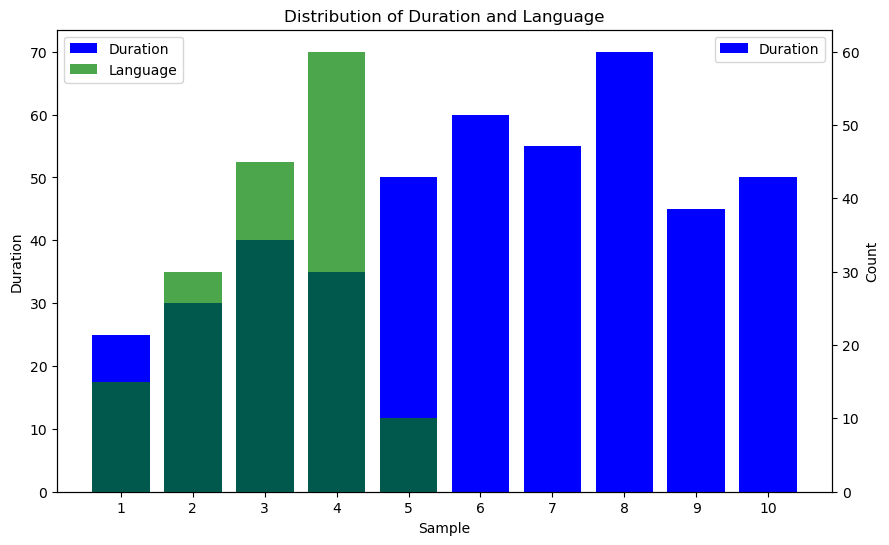

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data: duration distribution
duration_distribution = [25, 30, 40, 35, 50, 60, 55, 70, 45, 50]

# Sample data: language distribution (categorical)
languages = ['English', 'Spanish', 'French', 'German', 'Italian']
language_distribution = [15, 30, 45, 60, 10]

# Create a DataFrame for language distribution
language_df = pd.DataFrame({'Language': languages, 'Count': language_distribution})

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot duration distribution
ax1.bar(range(len(duration_distribution)), duration_distribution, color='blue', label='Duration')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Duration')
ax1.legend()

# Create a twin axis for the language distribution
ax2 = ax1.twinx()
ax2.bar(range(len(language_df)), language_df['Count'], color='green', alpha=0.7, label='Language')
ax2.set_ylabel('Count')
ax2.legend()

# Set x-axis ticks and labels
ax1.set_xticks(range(len(duration_distribution)))
ax1.set_xticklabels(range(1, len(duration_distribution) + 1))

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add title
plt.title('Distribution of Duration and Language')

# Display the plot
plt.show()








